Por Miguel Ángel Castañeda Martínez

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Visualización inicial

Primero hacemos una inspección rápida de las encuestas para identificar variables de interés

In [2]:
poll_data = pd.read_stata('./pew_research_center_june_elect_wknd_data.dta')

Nos quedamos con las variables [`state`, `survey`, `ideo`].

- `state`: Estado en el que se realizaró la encuesta.
- `survey`: Identificador de la encuesta aplicada en cada registro.
- `ideo`: Ideología política del encuestado.

**Paso 1**: Agrupamos los datos por estado para extraer las encuestas que se
aplicaron a cada uno.

In [3]:
state = poll_data.groupby(by='state').count()
state.reset_index(inplace=True)
state = state[['state', 'survey']]

In [4]:
ideo = poll_data.groupby(by=['state','ideo']).count()
ideo.reset_index(inplace=True)
ideo = ideo[['state', 'ideo', 'survey']]
very_liberal = ideo.loc[ideo['ideo'] == 'very liberal']

In [5]:
prop = pd.merge(left=state,
 right=very_liberal,
 how='left',
 on='state',
 suffixes=('_total','_very_lib'))

In [6]:
prop['prop_mle'] = prop['survey_very_lib'] / prop['survey_total']
#Se eliminan estados que no son de interés
prop = prop[~prop['state'].isin(['washington dc', 'hawaii', 'alaska'])]
prop.head()

,state,survey_total,ideo,survey_very_lib,prop_mle
0,alabama,624,very liberal,30,0.048077
1,arizona,542,very liberal,28,0.051661
2,arkansas,307,very liberal,7,0.022801
3,california,2854,very liberal,179,0.062719
4,colorado,468,very liberal,27,0.057692


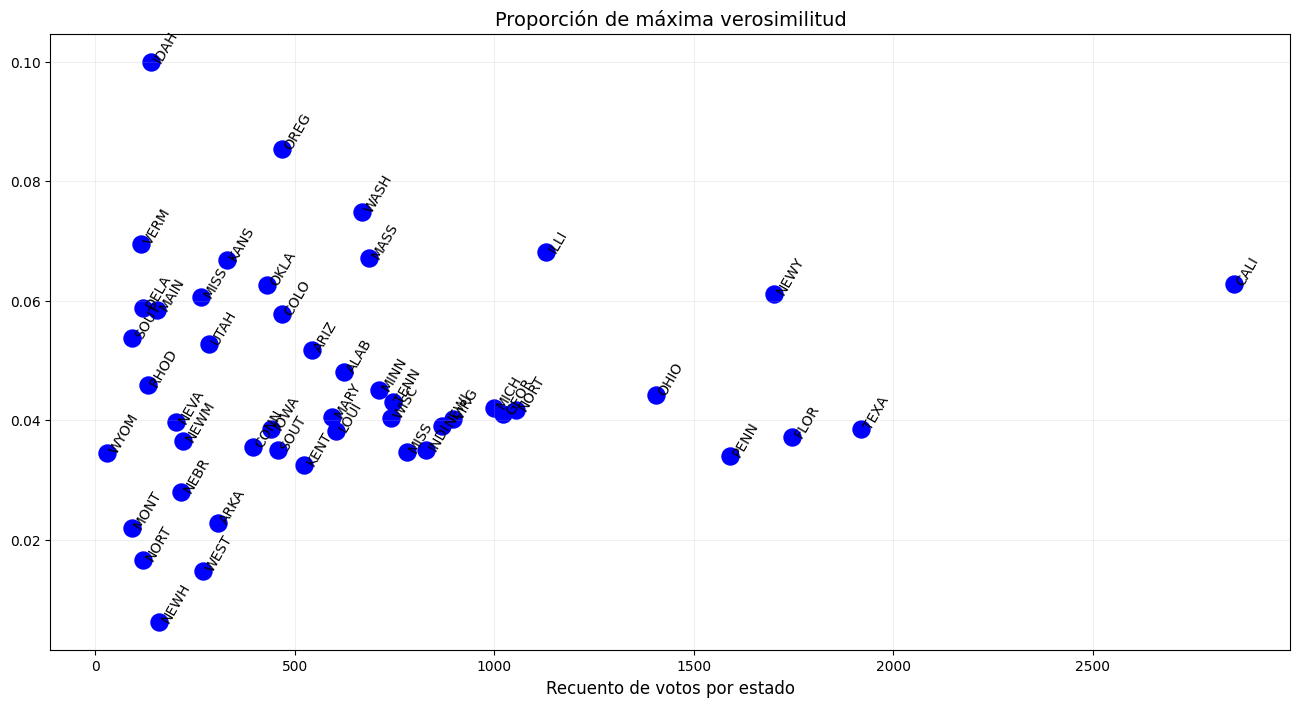

In [7]:
plt.figure(figsize=(16,8))
plt.scatter(x=prop['survey_total'], y=prop['prop_mle'], s=150, color='blue')
for idx in prop.index:
 x = prop.loc[idx]['survey_total']
 y = prop.loc[idx]['prop_mle']
 s = prop.loc[idx]['state'].upper().replace(' ', '')[0:4]
 plt.text(x=x, y=y, s=s, fontsize=10, rotation=60)
plt.title('Proporción de máxima verosimilitud', fontsize=14)
plt.xlabel('Recuento de votos por estado', fontsize=12)
plt.grid(alpha=0.2)
plt.show()

---